# Header

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext cython

In [123]:
font = {'size' : 16}
plt.rc('font', **font)
colmap=plt.cm.get_cmap(plt.cm.Blues)

## Excercise 13 (a)

$I = \int_0^b cos(x^2) \text{d}x$

$b = 15$

$\text{d}x =  0.001$

In [4]:
%%cython
cimport numpy as np
import random
import math
import numpy as np

cdef int    b = 15
cdef float dx = 0.001
cdef int    N = int( b/dx )


def fct(x):
    return np.cos(x**2)


def riemann( b=b, dx=dx, fct=fct):
    """ Evaluate the Riemann Sum for functions from 13 (ab)"""
    I = 0
    for k in range(int(b/dx)):
        I += dx*fct(k*dx)
    return I


def trapez(a, b, ya, yb):
    """ Returns the area of a trapeze spanned by a, b, ya, yb"""
    return 0.5*(ya + yb)*np.abs(b-a)


def montecarlo(N=N, b=b):
    """ For a given number of steps this returns the Integral with steps at randomly chosen base points"""
    
    # array for base points and corresponding function values
    cdef np.ndarray arr = np.empty([ N, 2], dtype=np.double) 
    
    # draw N random base points
    for i in np.arange(N):
        arr[i,0] = random.uniform(0,b)
    
    # sort the points for easier area calculation later
    arr = np.sort(arr, axis=0)
    
    # generate function values
    for i in np.arange(N):
        arr[i,1] = fct( arr[i,0] )
    
    # calculate first and last trapeze area individual
    I  = trapez(          0, arr[0,0], fct(0),     arr[0,1] )
    I += trapez( arr[N-1,0], b,        arr[N-1,1], fct(b)   )
    
    # calculate middle trapez areas
    for i in np.arange(N-1):
        I += trapez( arr[i,0] ,arr[i+1,0], arr[i,1], arr[i+1,1] )  
    
    return  I

In [ ]:
Nmax   = int(1e3)
factor = 10

In [ ]:
I_riemann    = riemann()
I_montecarlo = np.zeros(Nmax)

for N in np.arange( 1, Nmax+1 ):
    I_montecarlo[N-1] = montecarlo( N=N*factor )
    print( N, '\r', end='' )

In [81]:
err     = np.abs( I_riemann - I_montecarlo ) / I_riemann
err_avg = np.convolve( err, np.ones(10), mode='same' )

In [95]:
lastbigger1percent = np.nonzero( np.array(np.diff(err_avg<.01), dtype=int) )[0][-1]

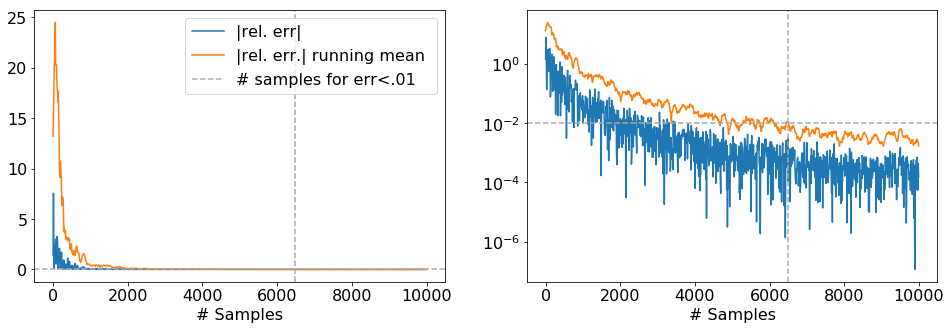

In [113]:
plt.close()

fig, axes = plt.subplots(1,2)
fig.set_size_inches( 1.618*10, 5 )

ticks = np.linspace(0,err.shape[0],6,dtype=int)
ticklabels = ticks*factor

for i in range(2):
    axes[i].plot(err[:], label='|rel. err|')
    axes[i].plot(err_avg[:], label='|rel. err.| running mean ')
    axes[i].axhline(0.01, linestyle='--', color='darkgrey', label='# samples for err<.01')
    axes[i].axvline(lastbigger1percent, linestyle='--', color='darkgrey')
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels(ticklabels)
    axes[i].set_xlabel('# Samples')

axes[0].legend()
axes[1].semilogy()

plt.show()

## Excercise 13 (b)

In [100]:
%%cython
cimport numpy as np
import random
import math
import numpy as np

cdef int    R = 1
cdef float dx = 0.001
cdef int    N = int( R/dx )


def fct_b(x):
    return 4*np.sqrt(R**2-(x)**2)


def riemann_b(R=R, N=N, fct=fct_b):
    dx=R/N
    I = 0
    for k in range(int(R/dx)):
        I += dx*fct_b(k*dx)
    return I


def montecarlo_b(N=N):
    ins = 0
    
    for i in np.arange(N):
        if random.uniform(0,1)**2+random.uniform(0,1)**2 <= 1: ins+=1
    
    return 4*(ins/N)
    

In [ ]:
Nmax = int(1e3)
factor=10

In [ ]:
I_riemann    = np.zeros(Nmax)
I_montecarlo = np.zeros(Nmax)

for N in np.arange( 1, Nmax+1 ):
    I_montecarlo[N-1] = montecarlo_b( N=N*factor )
    I_riemann[   N-1] = riemann_b(    N=N*factor )
    print(N,'\r',end='')

In [102]:
errRM = np.abs( I_riemann    - np.pi ) / np.pi
errMC = np.abs( I_montecarlo - np.pi ) / np.pi

err_avgRM = np.convolve( errRM, np.ones(10), mode='same' )
err_avgMC = np.convolve( errMC, np.ones(10), mode='same' )

In [114]:
plt.close()
fig, axes = plt.subplots(1,2)
fig.set_size_inches( 1.618*10, 5 )


ticks = np.linspace(0,errMC.shape[0],6,dtype=int)
ticklabels = ticks*factor

for i in range(2):
    axes[i].plot(errRM, label='|rel. err RM|')
    axes[i].plot(errMC, label='|rel. err MC|')
    axes[i].plot(err_avgRM, label='|rel. err RM| running mean')
    axes[i].plot(err_avgMC, label='|rel. err MC| running mean')
    axes[i].axhline(0.01, linestyle='--', color='darkgrey', label='# samples for err<.01')
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels(ticklabels)
    axes[i].set_xlabel('# Samples')

axes[0].legend()
axes[1].semilogy()
plt.show()

## Excercise 14

In [115]:
%%cython

cimport numpy as np
import random
import math
import numpy as np

cdef int    N  = 10
cdef double c1 = np.sqrt(2/np.pi)


def f(x):
    """ Density from which the random numbers should be drawn """
    return c1*np.exp(-x**2/2)


def t(x):
    """ This function majorizes the function f(x) """
    return 3/2*np.exp(-x)


def gen_Y(a=0,b=1):
    """ After inversion of r(x) = t(x) / \int(t(x)) draw from this distribution """
    Y = -np.log( random.uniform(a,b) )
    return Y


def check(i,arr):
    """ Check if a uniform random number <= f(y) /t (y) and accept"""
    Y = gen_Y()
    if random.uniform(0,1) <= f(Y)/t(Y): 
        arr[i] = Y
        i += 1
    return i

def neumann(N):
    """ Perform the Neumann Sampling for N Samples"""
    cdef np.ndarray arr = np.zeros([ N, 1], dtype=np.double)        
    i = 0
    while i < N:
        i = check(i,arr)
        
    return arr
    

In [117]:
hist = neumann(1000000)

In [122]:
plt.close()

x = np.linspace(0,5,100)

y1 = f(x)
y2 = t(x)

fig = plt.figure(figsize=(10,5))

plt.plot(x,y1, label=r'$f(x) = \sqrt{\frac{2}{\pi}}e^{\frac{-x^2}{2}}$')
plt.plot(x,y2, label=r'$t(x) = \frac{3}{2}e^{-x}$')

plt.hist(hist,normed=True, bins=55, facecolor='b', alpha=0.3, label='Histogram of Samples')

plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')

plt.legend()
plt.show()

# Ising Model - Exc 15

## Exc 15 (a)
Number of possible spin configurations for an LxL lattice with L=50

In [127]:
L = 50

In [128]:
2**(L*L)

375828023454801203683362418972386504867736551759258677056523839782231681498337708535732725752658844333702457749526057760309227891351617765651907310968780236464694043316236562146724416478591131832593729111221580180531749232777515579969899075142213969117994877343802049421624954402214529390781647563339535024772584901607666862982567918622849636160208877365834950163790188523026247440507390382032188892386109905869706753143243921198482212075444022433366554786856559389689585638126582377224037721702239991441466026185752651502936472280911018500320375496336749951569521541850441747925844066295279671872605285792552660130702047998218334749356321677469529682551765858267502715894007887727250070780350262952377214028842297486263597879792176338220932619489509376

In [129]:
(L*L)*np.log(2)/np.log(10)

752.57498915995291

In [130]:
%%cython

cimport numpy as np

import numpy as np
import random
import math


cdef int L = 50 # Size of lattice
cdef int N = L*L # Number of Spins    
    
    
def init_half_half( lattice ):
    
    for i in range( int(L/2) ):
        for j in range( L ):
            lattice[i,j] = -1
            
    return lattice

    
    
def init_random( lattice, p=.5 ):
    
    cdef int flipped = 0
    cdef int toflip  = int(p*N)
    
    while flipped < toflip:
        i = random.randint( 0, L-1 )
        j = random.randint( 0, L-1 )
        lattice[ i,j ] = -1
        flipped += 1
        
    return lattice
        

    
def d_U_4nn( i, j, lattice ):    
    """ Evaluate the change in Energy for a Spin Flip"""
    s = lattice[ i, j ]
    nn = np.sum( [ lattice[ i, (j+1)%L ], lattice[ (i+1)%L, j ] ,
                   lattice[ i, (j-1)%L ], lattice[ (i-1)%L, j ] ] )
    
    return 2*s*nn # minus sign in energy term -> -1*-1



def U_2nn( i, j, lattice ):    
    """ Take just 2 nn for full Lattice Energy Calculation """
    s = lattice[i, j]
    nn = np.sum( [ lattice[i,(j+1)%L], lattice[(i+1)%L,j] ] )
    
    return s*nn


    
def tot_U( lattice ):
    
    cdef int E = 0
    
    for i in range(L):
        for j in range(L):
            E += U_2nn(i,j, lattice)
    
    return E



def make_lattice(randlattice=False, p=.5 ):
    
    cdef np.ndarray lattice = np.full( [L,L], 1, dtype=np.int8)  # init lattice with all spins up '+1'

    if randlattice : # for (c) flip part p randomly down
        lattice = init_random( lattice, p )
        startlattice = lattice
        
    else           : # for (b) flip upper half down
        lattice = init_half_half( lattice )         
    
    return lattice


    
def mc_ising( lattice, steps=50000, beta=.3):
 
    cdef int U = tot_U( lattice )               # total Energy
    
    cdef float pU4 = np.exp(-beta*4)   # precalculated values-
    cdef float pU8 = np.exp(-beta*8)   # -for MC steps, 8 & 4    

    for step in range(steps):
        
        i = random.randint( 0, L-1 )
        j = random.randint( 0, L-1 )
        
        dU = d_U_4nn( i, j, lattice )
        
        if dU <= 0:
            lattice[i,j] *= -1
            U += dU
            #print('accept @ <0')#, lattice)

        else:
            
            r = random.uniform(0,1)
           
            if dU == 4:
                if r < pU4: 
                    lattice[i,j] *= -1
                    U += dU
                    #print('accept @ 4')#, lattice)
                    
            elif dU == 8:
                if r < pU8: 
                    lattice[i,j] *= -1
                    U += dU
                    #print('accept @ 8')#, lattice)

                    
    return lattice, U

In [131]:
%%timeit
lattice = make_lattice()
mc_ising(lattice)

2.26 s ± 87.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Exc 15 (b)

In [132]:
betas    = np.linspace(.1,.7,50)

lattices = np.zeros( (betas.shape[0], L,L) )
energies = np.zeros(  betas.shape[0] )
means    = np.zeros(  betas.shape[0] )

for i,beta in enumerate( betas ):
    print('starting temp:',beta, '\r',end="")
    lattice = make_lattice()
    tmp1, tmp2 = mc_ising( lattice, beta=beta )
    lattices[i] = tmp1
    energies[i] = tmp2
    means[i]    = np.mean(tmp1)
    
lattice = make_lattice()
tmp1, tmp2 = mc_ising( lattice, beta=beta, steps=0 )
lattices[0] = tmp1
energies[0] = tmp2
means[0]    = np.mean(tmp1)

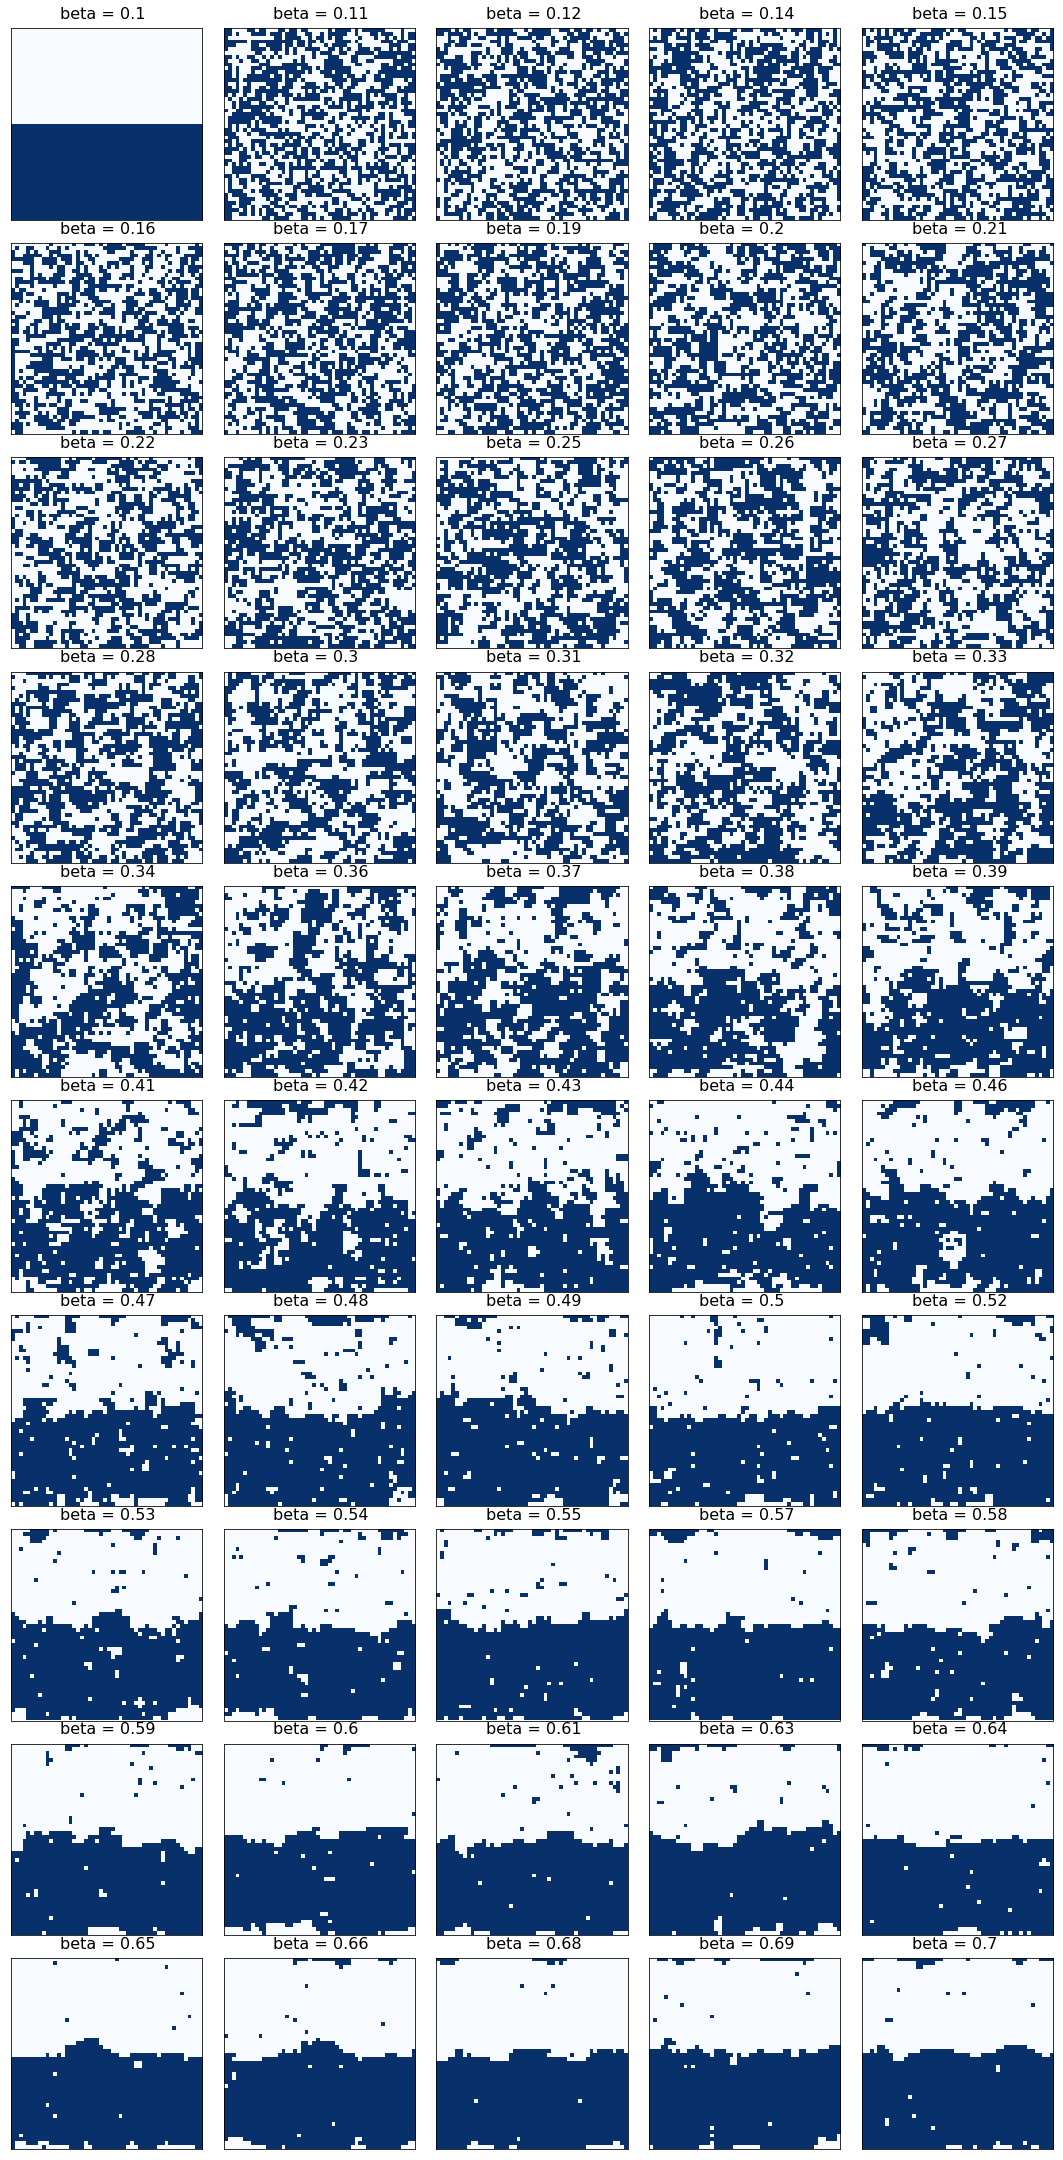

In [139]:
plt.close()

rows = 10
cols = int(np.ceil(betas.shape[0]/rows))

fig, axes = plt.subplots( nrows=rows, ncols=cols )
fig.set_size_inches( 3*cols, 3*rows )

for i,temp in enumerate(betas):
    a = int(np.floor(i/cols))
    b = i%cols
    axes[ a,b ].matshow( lattices[i] , cmap=colmap)
    axes[ a,b ].text(L/4,-3,'beta = '+str(np.round(betas[i],2)))
    axes[ a,b ].set_yticks([])
    axes[ a,b ].set_xticks([])
    
plt.tight_layout(pad=1)
plt.show()

## Exc 15 (c)

In [141]:
c_betas    = np.linspace( .1 , .7 , 4 )
c_ps       = np.linspace( .25, .75, 3 )

c_betas, c_ps

(array([ 0.1,  0.3,  0.5,  0.7]), array([ 0.25,  0.5 ,  0.75]))

In [142]:
c_lattices = np.zeros( (c_betas.shape[0], c_ps.shape[0], L,L) )
c_energies = np.zeros( (c_betas.shape[0], c_ps.shape[0]) )
c_means    = np.zeros( (c_betas.shape[0], c_ps.shape[0]) )

In [143]:
for bi,beta in enumerate( c_betas ):
    print('starting temp:',beta)
    
    for pi,p in enumerate( c_ps ):
        print('starting p:',p, '\r',end="")
        lattice = make_lattice( randlattice=True, p=p )
        tmp1, tmp2 = mc_ising( lattice, beta=beta )
        c_lattices[bi, pi] = tmp1
        c_energies[bi, pi] = tmp2
        c_means[bi, pi]    = np.mean(tmp1)
    

starting temp: 0.1
starting temp: 0.3
starting temp: 0.5
starting temp: 0.7


In [151]:
plt.close()

rows = 3
cols = 4

fig, axes = plt.subplots( nrows=rows, ncols=cols )
fig.set_size_inches( 3*cols, 3*rows )

for bi,beta in enumerate( c_betas ):    
    for pi,p in enumerate( c_ps ):
        
        axes[ pi,bi ].matshow( c_lattices[ bi,pi ] , cmap=colmap)
        axes[ pi,bi ].text(L/4,-3,'beta = '+str(c_betas[bi]))
        axes[ pi,bi ].text(L/4,-7,'p    = '+str(c_ps[pi]))
        axes[ pi,bi ].set_yticks([])
        axes[ pi,bi ].set_xticks([])
    
plt.tight_layout(pad=2)
plt.show()